In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [ ]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# Paths to directories
traindir = "/content/drive/MyDrive/Dataset/Train"
validdir = "/content/drive/MyDrive/Dataset/Val"
testdir = "/content/drive/MyDrive/Dataset/Test"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    rotation_range=50,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64

training_set = train_datagen.flow_from_directory(
    traindir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
)
valid_set = valid_datagen.flow_from_directory(
    validdir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(
    testdir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced', classes=np.unique(training_set.classes), y=training_set.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:10]:
    layer.trainable = False

# CBAM Attention Block
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_dense = layers.Dense(channel // ratio, activation='relu')
    avg_pool = shared_dense(layers.GlobalAveragePooling2D(keepdims=True)(input_feature))
    max_pool = shared_dense(layers.GlobalMaxPooling2D(keepdims=True)(input_feature))
    channel_att = layers.Add()([avg_pool, max_pool])
    channel_att = layers.Dense(channel, activation='sigmoid')(channel_att)
    input_feature = layers.Multiply()([input_feature, channel_att])
    avg_pool_sp = tf.reduce_mean(input_feature, axis=-1, keepdims=True)
    max_pool_sp = tf.reduce_max(input_feature, axis=-1, keepdims=True)
    spatial_att = layers.Concatenate(axis=-1)([avg_pool_sp, max_pool_sp])
    spatial_att = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_att)
    return layers.Multiply()([input_feature, spatial_att])

# Model Architecture
x = base_model.output
x = cbam_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(len(training_set.class_indices), activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Define metrics
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(num_classes=len(training_set.class_indices), average='macro', name='f1_score')
]

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=metrics
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_VGG16ATMN.h5', save_best_only=True, monitor='val_accuracy', verbose=1)

# Train the model
history = model.fit(
      training_set,
      steps_per_epoch=52,
      epochs=5,
      validation_data=valid_set,
      validation_steps=len(valid_set),
      class_weight=class_weights_dict,
      callbacks=[reduce_lr, early_stopping, model_checkpoint],
      verbose=1
)

# Save final model
model.save('/content/drive/MyDrive/best_model_VGG16ATMN.h5')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Found 7771 images belonging to 4 classes.
Found 1747 images belonging to 4 classes.
Found 196 images belonging to 4 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
52/52 [==============================] - ETA: 0s - loss: 2.1918 - accuracy: 0.4910 - precision: 0.5545 - recall: 0.4020 - f1_score: 0.4900  
Epoch 1: val_accuracy improved from -inf to 0.47968, saving model to /content/drive/MyDrive/best_model_VGG16ATMN.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 5056s 97s/step - loss: 2.1918 - accuracy: 0.4910 - precision: 0.5545 - recall: 0.4020 - f1_score: 0.4900 - val_loss: 1.8711 - val_accuracy: 0.4797 - val_precision: 0.5357 - val_recall: 0.2662 - val_f1_score: 0.4492 - lr: 1.0000e-04
Epoch 2/5
52/52 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.8253 - precision: 0.8680 - recall: 0.7770 - f1_score: 0.8249  
Epoch 2: val_accuracy improved from 0.47968 to 0.93589, saving model to /content/drive/MyDrive/best_model_VGG16ATMN.h5
52/52 [==============================] - 4955s 95s/step - loss: 1.5408 - accuracy: 0.8253 - precision: 0.8680 - recall: 0.7770 - f1_score: 0.8249 - val_loss: 1.3578 - val_accuracy: 0.9359 - val_precision: 0.9622 - val_recall: 0.8603 - val_f1_score: 0.9356 - lr: 1.0000e-04
Epoch 3/5
52/52 [==============================] - ETA: 0s - loss: 1.4113 - accuracy: 0.8894 - precision: 0.9160 - recall: 0.8511 - f1_score: 0.8903  
Epoch 3: val_accuracy did not imp

In [ ]:
# Evaluate the model
acc = model.evaluate(valid_set)[1]
print("The accuracy of your model is = ", acc * 100, " %")

28/28 [==============================] - 1091s 39s/step - loss: 1.1884 - accuracy: 0.9874 - precision: 0.9908 - recall: 0.9823 - f1_score: 0.9876
The accuracy of your model is =  98.74069690704346  %


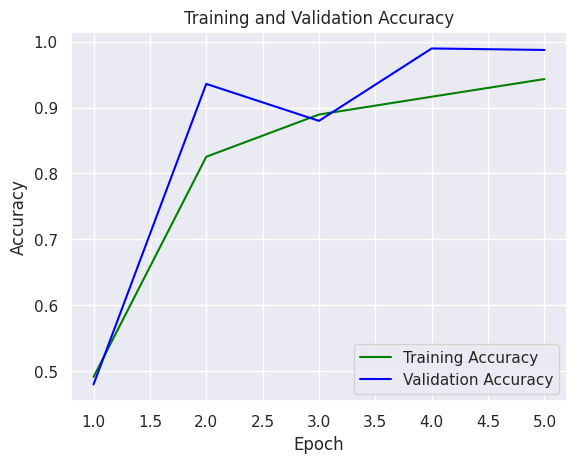

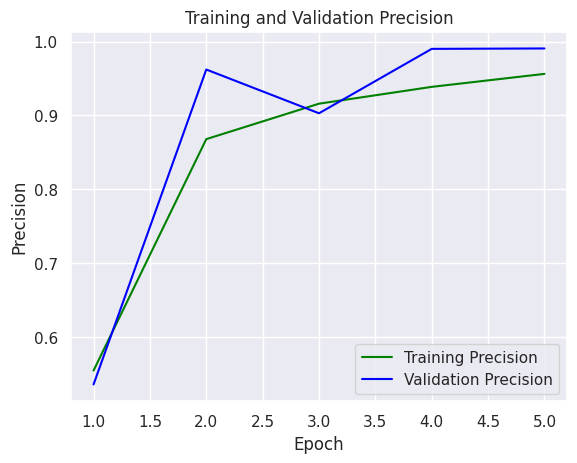

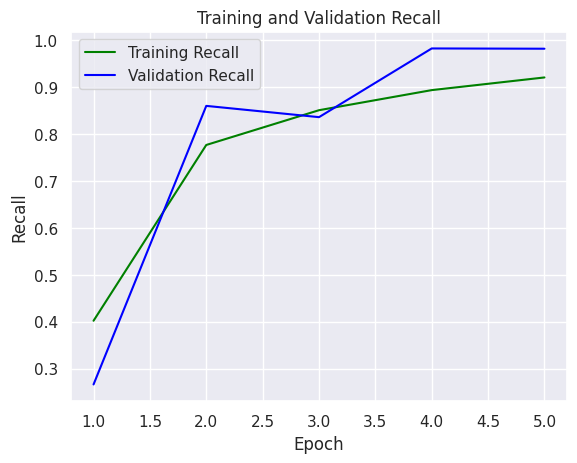

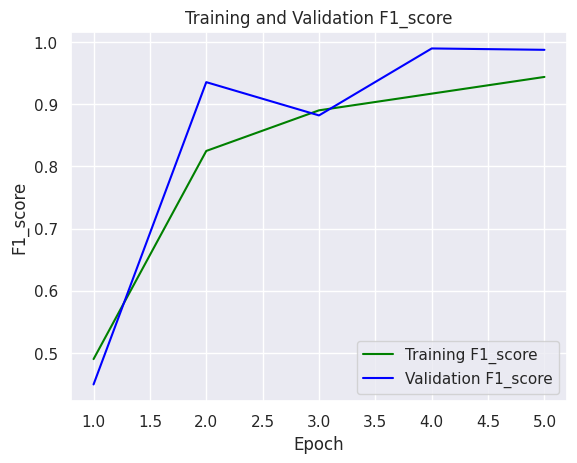

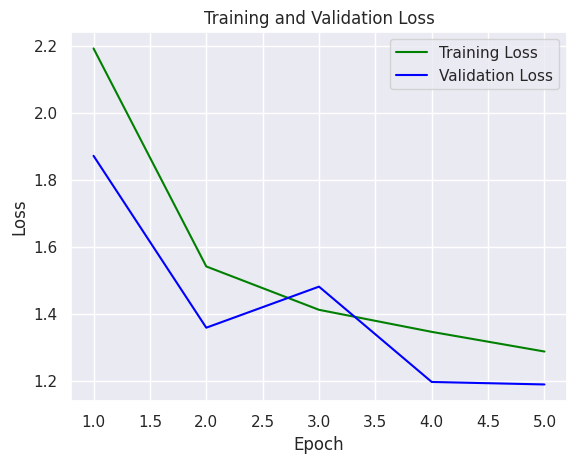

Following is our prediction:
1/1 [==============================] - 1s 545ms/step


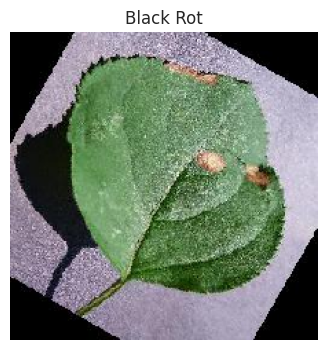

In [ ]:
# Plotting accuracy and loss
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Convert F1-score tensor list into a scalar list
f1_scores = [np.mean(f1) for f1 in history.history['f1_score']]
val_f1_scores = [np.mean(f1) for f1 in history.history['val_f1_score']]


epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# precision plot
plt.plot(epochs, precision, color='green', label='Training Precision')
plt.plot(epochs, val_precision, color='blue', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# recall plot
plt.plot(epochs, recall, color='green', label='Training Recall')
plt.plot(epochs, val_recall, color='blue', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

# f1_score plot
plt.plot(epochs, f1_scores, color='green', label='Training F1_score')
plt.plot(epochs, val_f1_scores, color='blue', label='Validation F1_score')
plt.title('Training and Validation F1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend()

plt.figure()


# Loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Prediction example
from tensorflow.keras.preprocessing import image

image_path = "/content/drive/MyDrive/Dataset/Test/Black Rot/6b078700-56e6-4d25-a18a-b7b90741a2d3___JR_FrgE.S 2963_new30degFlipLR.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img / 255

# Get class names from the training set
class_names = list(training_set.class_indices.keys()) # Added this line to define class_names

print("Following is our prediction:")
prediction = model.predict(img)
d = prediction.flatten()
j = d.max()
for index, item in enumerate(d):
    if item == j:
        class_name = class_names[index]

# Plotting image with predicted class name
plt.figure(figsize=(4, 4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [ ]:
!pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
!npm install -g localtunnel
!streamlit run '/content/drive/MyDrive/Colab Notebooks/new app.py' & sleep 5 && npx localtunnel --port 8501

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00
34.173.60.53
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 3s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.173.60.53:8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙your url is: https://flat-ads-trade.loca.lt
2025-03-27 15:20:49.897282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 15:20:49.897338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cu

In [ ]:
# STEP 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tqdm import tqdm
import os


In [ ]:
# Load your saved VGG16-attention model
model = load_model('/content/drive/MyDrive/best_model_VGG19.h5')

# Define target image size and classes
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
CLASS_NAMES = ['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']

# Load Test Set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/Test',  # Update path accordingly
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 196 images belonging to 4 classes.


In [ ]:
# Extract output from a specific intermediate layer (can change to attention layer too)
intermediate_layer_name = 'block5_conv3'  # or your CBAM layer
feature_model = Model(inputs=model.input,
                      outputs=model.get_layer(intermediate_layer_name).output)


In [ ]:
# Prepare dictionary to store per-class activations
activations_per_class = {i: [] for i in range(len(CLASS_NAMES))}

# Extract images and labels
x_test, y_test = [], []
for i in range(len(test_generator)):
    x, y = test_generator[i]
    x_test.append(x)
    y_test.append(y)
    if (i+1)*BATCH_SIZE >= test_generator.samples:
        break

x_test = np.vstack(x_test)
y_test = np.vstack(y_test)

# Pass each image and collect activations
for i in tqdm(range(len(x_test))):
    img = x_test[i][np.newaxis, ...]
    label = np.argmax(y_test[i])
    activation = feature_model.predict(img, verbose=0)
    mean_activation = np.mean(activation[0], axis=(0, 1))  # Average across spatial dims
    activations_per_class[label].append(mean_activation)


100%|██████████| 196/196 [03:07<00:00,  1.05it/s]


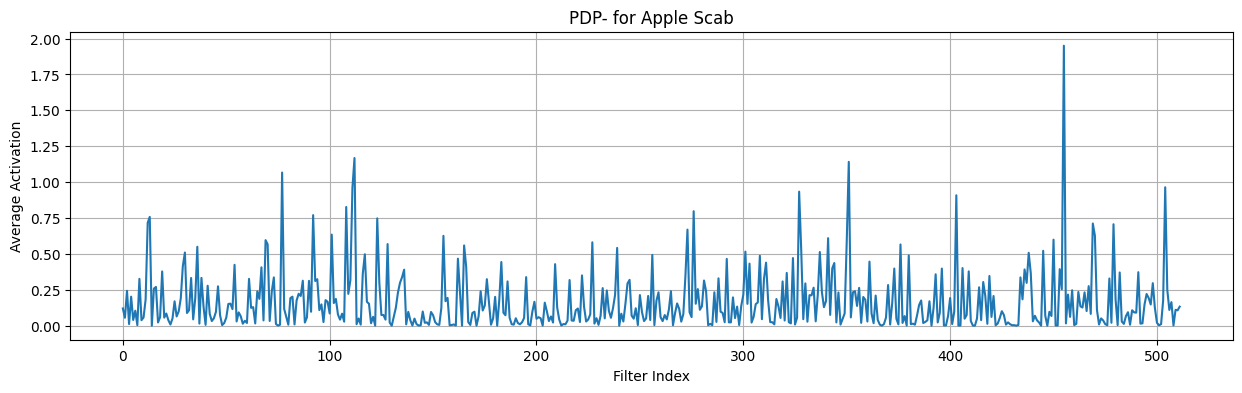

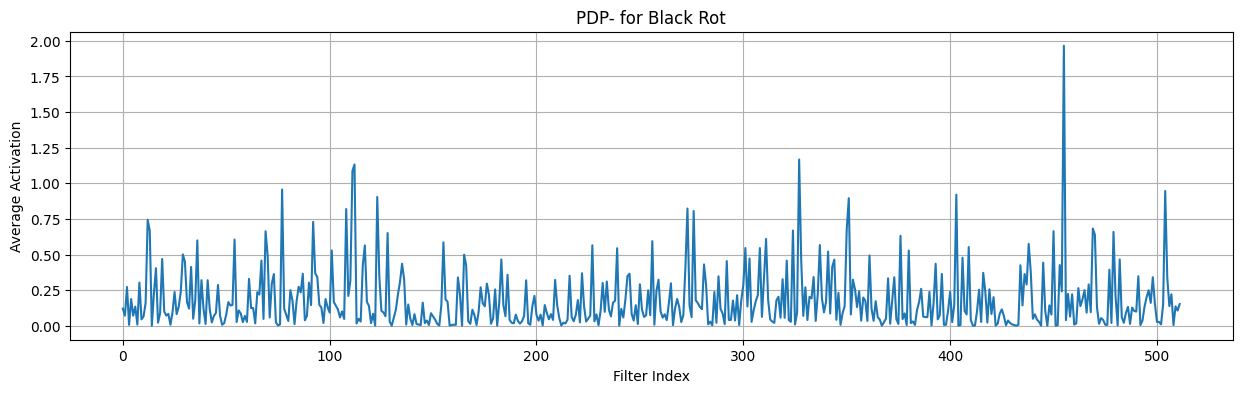

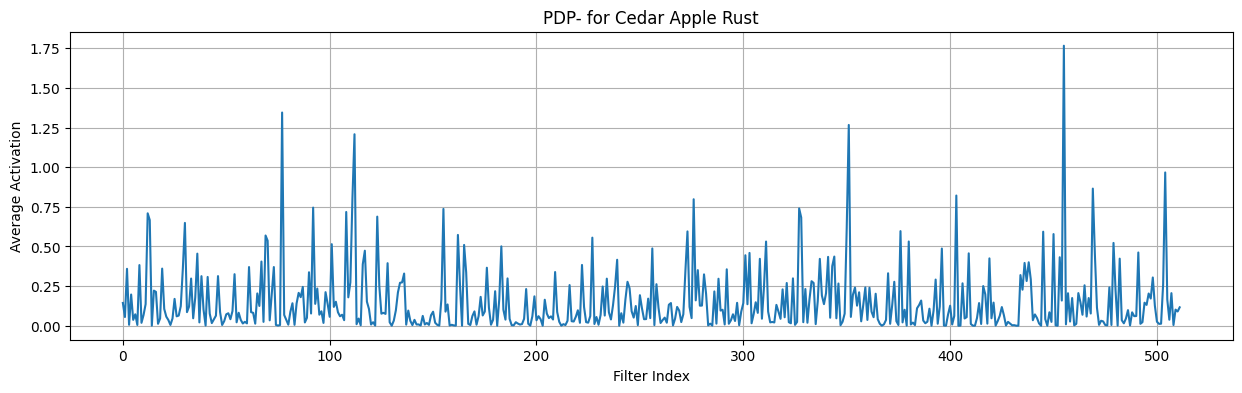

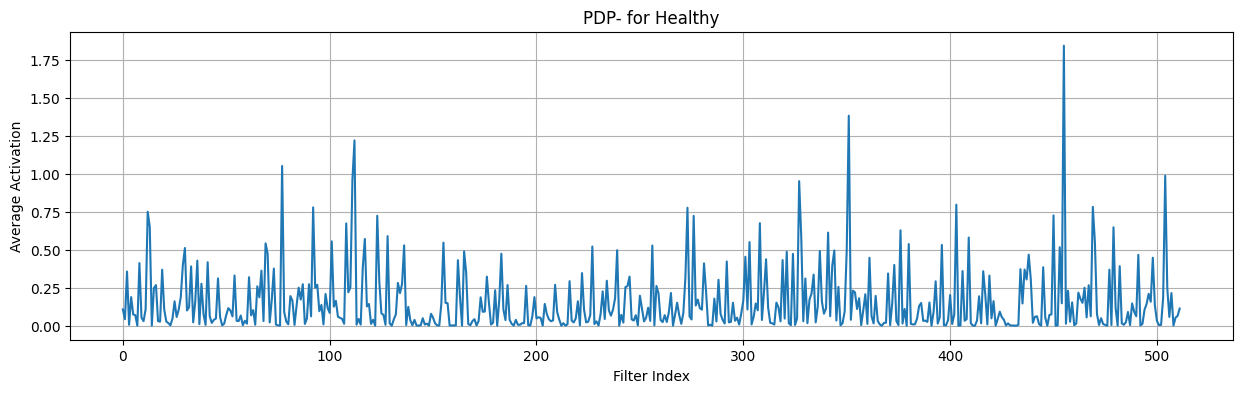

In [ ]:
# Plot average filter activations (like PDPs)
num_filters = activations_per_class[0][0].shape[0]

for class_index, class_name in enumerate(CLASS_NAMES):
    plt.figure(figsize=(15, 4))
    mean_act = np.mean(activations_per_class[class_index], axis=0)
    plt.plot(range(num_filters), mean_act)
    plt.title(f'PDP- for {class_name}')
    plt.xlabel('Filter Index')
    plt.ylabel('Average Activation')
    plt.grid(True)
    plt.show()
